# Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making.

This dataset is taken from: https://archive.ics.uci.edu/dataset/19/car+evaluation

* buying: buying price
*	maint: price of the maintenance
*	doors: Number of doors
*	persons: capacity in terms of persons to carry
*	lug_boot: the size of luggage boot
*	safety: estimated safety of the car
*	target: decision to buy

### Importing the required libraries

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [119]:
# Fetch the Car Evaluation dataset from UCI
car_evaluation = fetch_openml(name='car', version=3)

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data=car_evaluation.data, columns=car_evaluation.feature_names)
df['target'] = car_evaluation.target

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [120]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [121]:
len(df)

1728

### Exploratory Data Analysis

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   buying    1728 non-null   category
 1   maint     1728 non-null   category
 2   doors     1728 non-null   category
 3   persons   1728 non-null   category
 4   lug_boot  1728 non-null   category
 5   safety    1728 non-null   category
 6   target    1728 non-null   category
dtypes: category(7)
memory usage: 13.1 KB


In [123]:
df.isna().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
target      0
dtype: int64

In [124]:
df.nunique()

buying      4
maint       4
doors       4
persons     3
lug_boot    3
safety      3
target      4
dtype: int64

In [125]:
df.doors.value_counts()

2        432
3        432
4        432
5more    432
Name: doors, dtype: int64

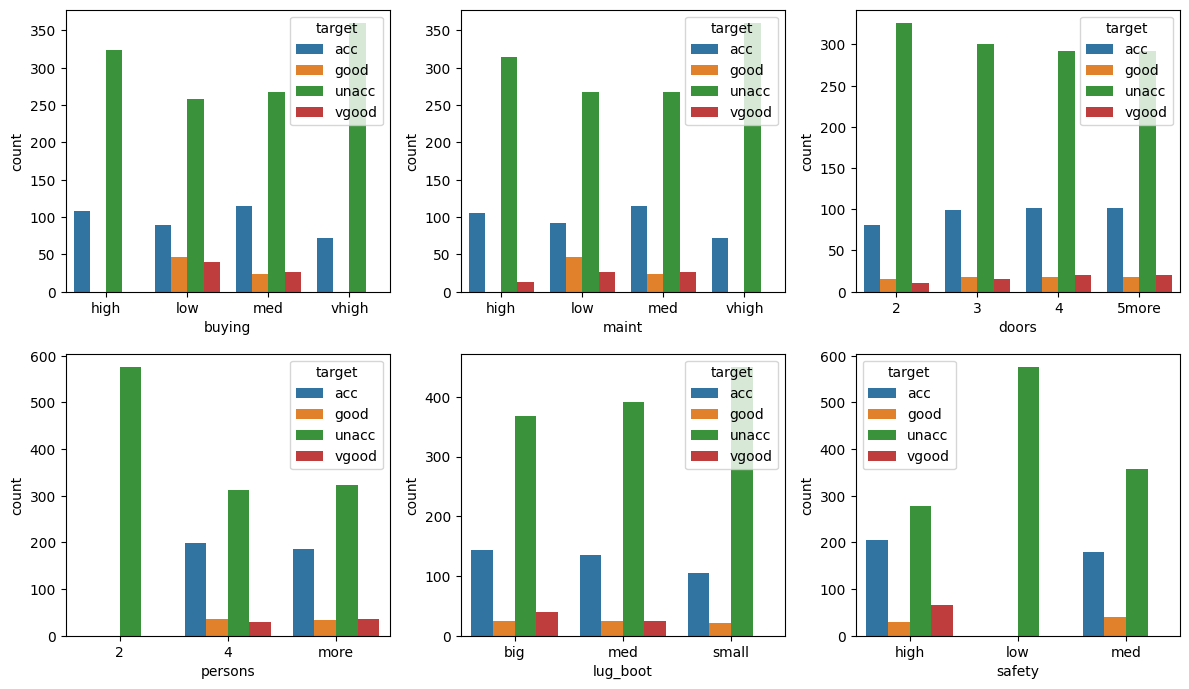

In [126]:
plt.figure(figsize=(12, 10))

for i, col in enumerate(df.columns):
  if col != 'target':
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=df, x=col, hue='target')

plt.tight_layout()
plt.show();

In [127]:
df['persons'].value_counts()

2       576
4       576
more    576
Name: persons, dtype: int64

### Preprocessing the data

In [128]:
df.value_counts()

buying  maint  doors  persons  lug_boot  safety  target
high    high   2      2        big       high    unacc     1
med     med    4      4        med       med     acc       1
                      more     small     low     unacc     1
                                         high    acc       1
                               med       med     acc       1
                                                          ..
low     low    3      2        med       med     unacc     1
                                         low     unacc     1
                                         high    unacc     1
                               big       med     unacc     1
vhigh   vhigh  5more  more     small     med     unacc     1
Length: 1728, dtype: int64

In [129]:
print(f"Doors: \n{df['doors'].value_counts()}")
print(f"Persons: \n{df['persons'].value_counts()}")

Doors: 
2        432
3        432
4        432
5more    432
Name: doors, dtype: int64
Persons: 
2       576
4       576
more    576
Name: persons, dtype: int64


In [130]:
df

,buying,maint,doors,persons,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [131]:
x = df.drop('target', axis=1)
y = df['target']

In [132]:
y = y.map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})

In [133]:
y.value_counts()

0    1210
1     384
2      69
3      65
Name: target, dtype: int64

In [134]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

len(x_train), len(x_test), len(y_train), len(y_test)

(1382, 346, 1382, 346)

In [135]:
ordinal_encoder = OrdinalEncoder(categories='auto')

x_train = ordinal_encoder.fit_transform(x_train)
x_test = ordinal_encoder.transform(x_test)

In [136]:
x_train, x_test, y_train, y_test

(array([[3., 3., 3., 2., 0., 0.],
        [2., 3., 1., 1., 2., 2.],
        [1., 1., 3., 0., 0., 0.],
        ...,
        [0., 1., 3., 2., 1., 0.],
        [1., 0., 2., 0., 2., 2.],
        [2., 2., 1., 2., 2., 2.]]),
 array([[0., 0., 2., 0., 1., 0.],
        [2., 1., 0., 1., 1., 2.],
        [0., 0., 3., 0., 0., 2.],
        ...,
        [2., 1., 0., 2., 2., 1.],
        [3., 3., 3., 2., 2., 0.],
        [2., 2., 0., 0., 1., 2.]]),
 107     0
 901     0
 1709    0
 706     0
 678     0
        ..
 1130    3
 1294    2
 860     1
 1459    0
 1126    1
 Name: target, Length: 1382, dtype: category
 Categories (4, int64): [1, 2, 0, 3],
 599     0
 1201    1
 628     0
 1498    1
 1263    0
        ..
 100     0
 274     0
 1206    0
 101     0
 1084    0
 Name: target, Length: 346, dtype: category
 Categories (4, int64): [1, 2, 0, 3])

In [137]:
# function for evaluating the models
def eval_score(model, x_test, y_test):

  y_pred = model.predict(x_test)

  dict={
      "accuracy": accuracy_score(y_test, y_pred),
      "precision": precision_score(y_test, y_pred, average='weighted'),
      "recall": recall_score(y_test, y_pred, average='weighted'),
      "f1": f1_score(y_test, y_pred, average='weighted')
  }
  return dict

In [138]:
def modelling(x_train, x_test, y_train, y_test):

  logistic_regression_model = LogisticRegression()
  random_forest_model = RandomForestClassifier()
  xgboost_model = XGBClassifier()


  logistic_regression_model.fit(x_train, y_train)
  random_forest_model.fit(x_train, y_train)
  xgboost_model.fit(x_train, y_train)


  dict={
      "lr_score": eval_score(model=logistic_regression_model, x_test=x_test, y_test=y_test),
      "rfc_score": eval_score(model=random_forest_model, x_test=x_test, y_test=y_test),
      "xgb_score": eval_score(model=xgboost_model, x_test=x_test, y_test=y_test)
  }
  return dict

In [139]:
data = modelling(x_train, x_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [140]:
results = pd.DataFrame(data)
results

,lr_score,rfc_score,xgb_score
accuracy,0.658960,0.965318,0.979769
precision,0.554108,0.972216,0.985781
recall,0.658960,0.965318,0.979769
f1,0.593189,0.966911,0.981074
